# Makie.jl - Animation

https://makie.juliaplots.org/stable/documentation/animation/

## 属性アニメーション

`lines` 等のプロッティング関数は Figure オブジェクト, 軸, Plot オブジェクト を返す

アニメーションは、Figure オブジェクトに対して `record(animation_function::Function, save_file::String, frames::Base.OneTo; ...kwargs)` 関数を実行することで生成できる

最も簡単なのは、生成した Plot オブジェクトの属性を変化させるアニメーションで、`animation_function` 関数内で Plot 属性を設定するだけで良い

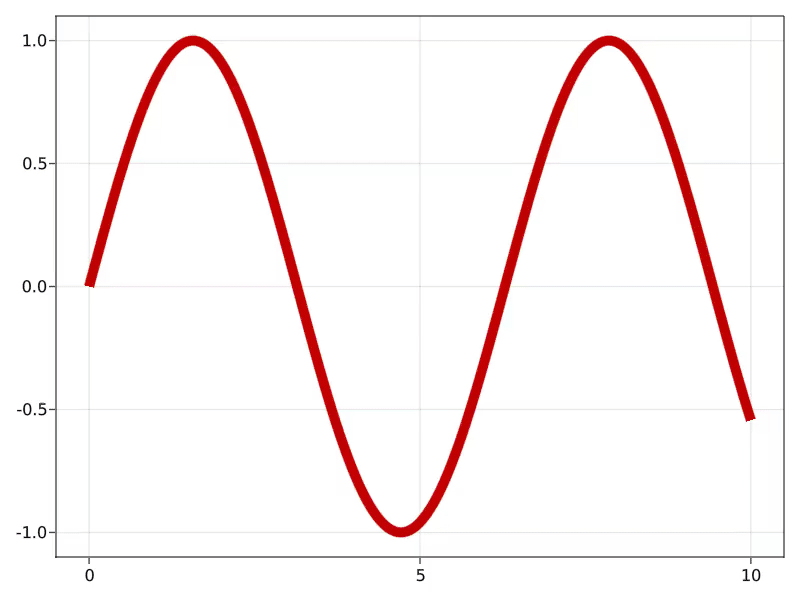

In [2]:
using GLMakie
using Makie.Colors

n_frames = 30
framerate = 30

fig, ax, lineplot = lines(0..10, sin; linewidth = 10)

record(
    fig,
    "02-animation-color.gif",
    range(0, 360, length = n_frames);
    framerate = framerate
) do hue
    lineplot.color = HSV(hue, 1, 0.75)
end

display("image/gif", read("02-animation-color.gif"))

## `Observable` オブジェクトアニメーション

より複雑なプロットアニメーションを行いたい場合は、`Observable` オブジェクトを用いる

大抵の場合、アニメーションは時間の経過とともに変化するものであるため、タイムスタンプに対する Observable オブジェクトを一つ作れば、アニメーションの進行中にすべてのプロットデータを手動で変更する必要はない

Observable オブジェクトに依存する関数は `@lift` マクロで示すことができる

以下、タイムスタンプごとに sine wave, cosine wave を動かす例を示す

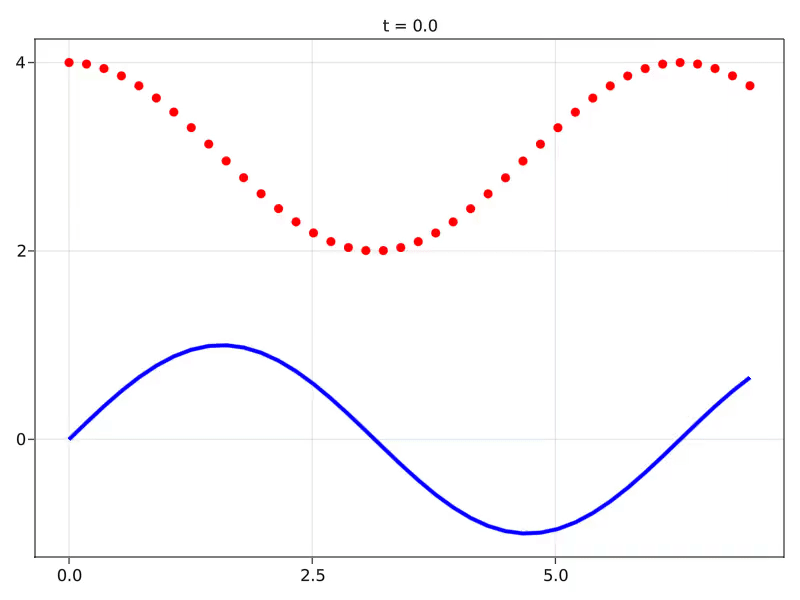

In [9]:
# タイムスタンプ依存の Observable オブジェクト
time = Observable(0.0)

xs = range(0, 7; length = 40)

# Observable time 依存の sine wave
sine_ys = @lift(sin.(xs .- $time))

# Observable time 依存の cosine wave
cosine_ys = @lift(cos.(xs .- $time) .+ 3)

fig = lines(
    xs,
    sine_ys,
    color = :blue,
    linewidth = 4,
    axis = (title = @lift("t = $(round($time, digits = 1))"),)
)
scatter!(xs, cosine_ys, color = :red, makersize = 15)

framerate = 30
timestamps = range(0, 2, step = 1 / framerate)

record(fig, "02-animation-observable.gif", timestamps; framerate = framerate) do timestamp
    time[] = timestamp
end

display("image/gif", read("02-animation-observable.gif"))

## Samples

### 迷路問題
- Documents
    - [Figure](https://makie.juliaplots.org/v0.17.3/documentation/figure/)
    - [Axis](https://makie.juliaplots.org/v0.17.3/examples/blocks/axis/index.html)
    - [Plotting functions > lines](https://makie.juliaplots.org/v0.17.3/examples/plotting_functions/lines/)
    - [Plotting functions > text](https://makie.juliaplots.org/v0.17.3/examples/plotting_functions/text/)

In [4]:
using GLMakie, Distributions

"""
 S0   S1   S2
     ----┐
 S3   S4 | S5
         └---
 S6 | S7   S8
"""
# 状態 => プロット位置マッピング
state_positions = [
    Point2f(0.5, 2.5), # S0
    Point2f(1.5, 2.5), # S1
    Point2f(2.5, 2.5), # S2
    Point2f(0.5, 1.5), # S3
    Point2f(1.5, 1.5), # S4
    Point2f(2.5, 1.5), # S5
    Point2f(0.5, 0.5), # S6
    Point2f(1.5, 0.5), # S7
    Point2f(2.5, 0.5), # S8
]

# エージェントの方策パラメータ
## 表形式方策の行動確率
## - 行: 状態
## - 列: ↑ → ↓ ← に移動する行動確率
##   - 壁のある方向には移動できないため行動確率は 0.0 になる
pi_0 = [
    0.0  0.5  0.5  0.0  # S0
    0.0  0.5  0.0  0.5  # S1
    0.0  0.0  0.5  0.5  # S2
    0.3  0.3  0.3  0.0  # S3
    0.0  0.0  0.5  0.5  # S4
    1.0  0.0  0.0  0.0  # S5
    1.0  0.0  0.0  0.0  # S6
    0.5  0.5  0.0  0.0  # S7
                        # S8 はゴールため方策不要
]

"""
    maze_plot() = fig::Figure, plt::GridPosition, ax::Axis

迷路描画
"""
maze_plot() = begin
    # 500x500 の Figure 作成
    fig = Figure(resolution = (500, 500))

    # Figure grid layout (1, 1) を描画対象にする
    plt = fig[1, 1]
    ax = Axis(plt) # 軸は必ず作成する必要がある (少し時間がかかる)

    # 描画範囲の設定
    xlims!(ax, 0, 3)
    ylims!(ax, 0, 3)

    # 軸の目盛りを非表示化
    ## グリッド線は表示する (grid = false)
    hidedecorations!(ax, grid = false)

    # 赤い壁を描画
    lines!(plt, [1, 1], [0, 1], color = :red, linewidth = 2)
    lines!(plt, [1, 2], [2, 2], color = :red, linewidth = 2)
    lines!(plt, [2, 2], [2, 1], color = :red, linewidth = 2)
    lines!(plt, [2, 3], [1, 1], color = :red, linewidth = 2)

    # 状態を示す文字 S0 ~ S8 を描画
    text!(plt, "S0", position = (0.5, 2.5), size = 14, align = (:center, :center))
    text!(plt, "S1", position = (1.5, 2.5), size = 14, align = (:center, :center))
    text!(plt, "S2", position = (2.5, 2.5), size = 14, align = (:center, :center))
    text!(plt, "S3", position = (0.5, 1.5), size = 14, align = (:center, :center))
    text!(plt, "S4", position = (1.5, 1.5), size = 14, align = (:center, :center))
    text!(plt, "S5", position = (2.5, 1.5), size = 14, align = (:center, :center))
    text!(plt, "S6", position = (0.5, 0.5), size = 14, align = (:center, :center))
    text!(plt, "S7", position = (1.5, 0.5), size = 14, align = (:center, :center))
    text!(plt, "S8", position = (2.5, 0.5), size = 14, align = (:center, :center))
    text!(plt, "START", position = (0.5, 2.3), size = 14, align = (:center, :center))
    text!(plt, "GOAL", position = (2.5, 0.3), size = 14, align = (:center, :center))

    fig, plt, ax
end

"""
    agent_plot!(plt::GridPosition, init_pos::Point) = agent_pos::Observable{<:Point}

エージェント: 初期プロット (赤色半透明のドットで表現)
"""
agent_plot!(plt::GridPosition, init_pos::Point) = begin
    agent_pos = Observable(init_pos)
    scatter!(plt, agent_pos, color = (:red, 0.5), markersize = 50)

    agent_pos
end

"""
    next_state(pi::Matrix{<:Number}, state::Int) = state_next::Int

1step 後の状態 s を求める関数

- `pi::Matrix{Number}`: 方策 π
- `state::Int`: 現在の状態 1..8
    - 1: S0, 2: S1, ... 8: S7
"""
next_state(pi::Matrix{<:Number}, state::Int) = begin
    directions = [:up, :right, :down, :left]

    # 行動を決定
    ## Distributions.wsample(samples::Vector, weights::Vector) = choiced_sample
    ### samples の中から任意の値を1つ選択する。ただしその選択確率は weights で定められた重みによって決められる
    direction_next = wsample(directions, pi[state, :])

    # 状態遷移
    # - 上: 状態 - 3
    # - 右: 状態 + 1
    # - 下: 状態 + 3
    # - 左: 状態 - 1
    state_transitions = Dict(
        :up    => -3,
        :right => +1,
        :down  => +3,
        :left  => -1,
    )
    state_next = state + state_transitions[direction_next]
end

"""
    maze(pi::Matrix{<:Number}) = state_history::Vector{Int}

迷路内をエージェントがゴールするまで移動させる関数

ゴールするまでにエージェントが通った状態の軌跡 state_history を返す
"""
maze(pi::Matrix) = begin
    # スタート地点: S0, ゴール地点: S8
    start, goal = 1, 9

    state::Int = start # 状態: 初期値 = S0
    state_history::Vector{Int} = [1] # エージェントの移動記録

    # ゴールするまで step を繰り返す
    while state !== goal
        state = next_state(pi, state)
        push!(state_history, state)
    end

    state_history
end

maze

In [2]:
state_history = maze(pi_0)

111-element Vector{Int64}:
 1
 4
 5
 4
 1
 2
 3
 6
 3
 2
 1
 2
 1
 ⋮
 2
 1
 4
 5
 4
 7
 4
 5
 8
 5
 8
 9

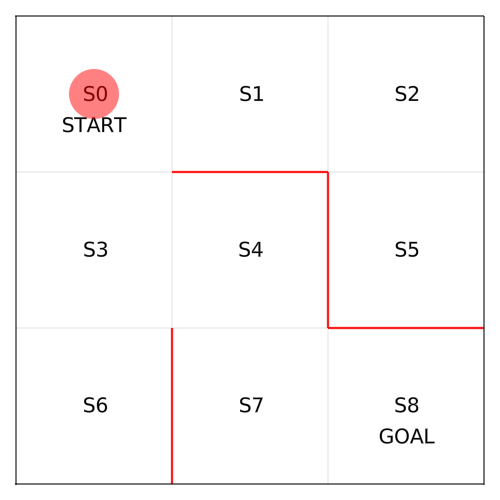

In [5]:
# 迷路描画
fig, plt, ax = maze_plot()

# エージェント描画
agent_pos = agent_plot!(plt, state_positions[1])

fig

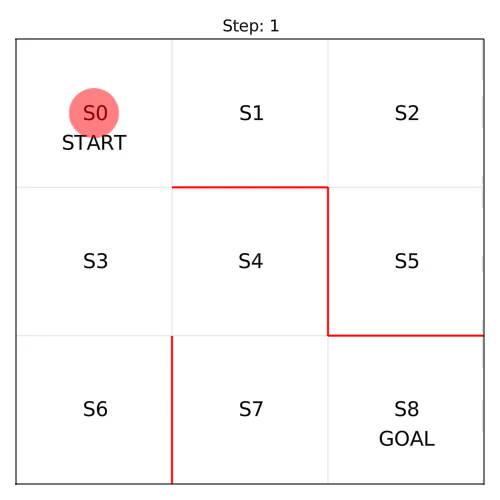

In [7]:
# エージェントの行動記録を GIF 動画に保存
filename = "02-animation-maze.gif"
record(fig, filename, 1:length(state_history);
    # state_history::Vector{状態::Int} を10秒でアニメーションさせるように framerate 設定
    framerate = ceil(Int, length(state_history) / 10)
) do frame
    # エージェント位置更新
    agent_pos[] = state_positions[state_history[frame]]

    # プロットタイトル更新
    ax.title = "Step: $frame"
end

display("image/gif", read(filename))